Importing packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import BaselineOnly, accuracy
from surprise.accuracy import rmse

In [3]:
#from sklearn.neighbors import NearestNeighbors
from numpy import array
from numpy.linalg import norm

from operator import itemgetter
import timeit

In [4]:
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import BaselineOnly, accuracy
from surprise.accuracy import rmse
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV

Loading in data

In [5]:
filepath = 'C:/Users/rl3079/Columbia/AppliedDataScience/prj4/'

In [6]:
full = pd.read_csv('full.csv')

In [7]:
full.head()

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,1,1,3.0,964982703
1,1,1,3,3.0,964981247
2,2,1,6,3.0,964982224
3,3,1,44,4.0,964983815
4,4,1,47,4.0,964982931


In [8]:
full_data = full[['userId', 'movieId', 'rating']]

In [9]:
full_data.head()

,userId,movieId,rating
0,1,1,3.0
1,1,3,3.0
2,1,6,3.0
3,1,44,4.0
4,1,47,4.0


In [10]:
#train_np = train[['userId','movieId','rating']].values
#train_np = train_np.astype(np.int)
#test_np = test[['userId','movieId','rating']].values
#test_np = test_np.astype(np.int)

In [11]:
num_users = len(full.userId.unique())
num_movies = len(full.movieId.unique())
#num_movies = full['movieId'].unique().max()
print(num_users)
print(num_movies)

610
9724


In [12]:
len(full_data)

100836

In [13]:
reader = Reader()
data = Dataset.load_from_df(full_data, reader)

In [14]:

train, test = train_test_split(data, test_size = 0.2)

In [15]:

iterator = train.all_ratings()
new_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in iterator:
    new_df.loc[i] = [uid, iid, rating]
    i = i+1

new_df.head(2)

,uid,iid,rating
0,0.0,0.0,4.0
1,0.0,98.0,3.5


In [16]:

min(new_df.rating.unique())

0.0

In [17]:
new_df['uid'] = new_df['uid'] + 1
new_df['iid'] = new_df['iid'] + 1

In [18]:

train_df = new_df
train_df.head()

,uid,iid,rating
0,1.0,1.0,4.0
1,1.0,99.0,3.5
2,1.0,233.0,4.0
3,1.0,190.0,3.5
4,1.0,399.0,4.5


In [19]:

test_df = pd.DataFrame(test, columns = ['uid', 'iid', 'rating'])

In [20]:
train_df.to_csv('train_split_by_surprise.csv')
test_df.to_csv('test_split_by_surprise.csv')

In [21]:
min(test_df.rating.unique())

0.5

In [22]:
len(test) + len(new_df)

100836

In [23]:

train_np = train_df[['uid','iid','rating']].values
train_np = train_df.astype(np.int)
test_np = test_df[['uid','iid','rating']].values
test_np = test_df.astype(np.int)

In [24]:

len(new_df)

80668

In [25]:
def format_output(I,M,U):
    approximation = np.multiply(I,np.dot(U.T,M))
    with open('output.txt','w') as f:  
        for i in range(610): # users
            for j in range(9724): # movies
                if approximation[i,j] != 0:
                    f.write("%d\t%d\t%f\n"%(i+1,j+1,approximation[i,j]))

formula to calculate rsme

In [26]:

def rmse(I,R,M,U,round=False):
    return np.sqrt(np.sum(np.square(np.multiply(I, (R-np.dot(U.T,M)))))/np.count_nonzero(I))

In [27]:
train_mat = train_np[['uid', 'iid', 'rating']].values
test_mat = test_np[['uid', 'iid', 'rating']].values

In [28]:
train_mat[0]

array([1, 1, 4])

In [29]:
R = np.asmatrix(np.zeros((num_users,num_movies), dtype=np.int)) # sparse rating matrix
for row in train_mat:
    user = row[0] - 1  # users start with id 1
    movie = row[1] - 1
    rating = row[2]
    R[user, movie] = rating

In [30]:
Rtst = np.asmatrix(np.zeros((num_users,num_movies), dtype=np.int))
for row in test_mat:
    user = row[0] - 1
    movie = row[1] - 1
    rating = row[2]
    Rtst[user,movie] = rating

In [31]:
# Indicator Matrices
I = np.copy(R)
I[I > 0] = 1
I[I == 0] = 0
I2 = np.copy(Rtst)
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [32]:
# ALS Parameters
l = 0.1       # Regularization parameter lambda
k = 0         # convergence iterator
K = 5        # convergence criterion
r = 10      # Dimensionality of latent feature space
m,n = R.shape # Number of users and items

In [33]:
np.random.seed(0)
np.seterr(divide='ignore', invalid='ignore') # supress divide by zero warning

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [34]:
# Initialize matricies
U = 1 * np.random.rand(r,m) # Latent user feature matrix (pattern matrix)
M = 1 * np.random.rand(r,n) # Latent movie feature matrix (coefficient matrix)
avg_movies = np.divide(R.sum(0),(R!=0).sum(0))
avg_movies[np.isnan(avg_movies)] = 0
M[0,:] = avg_movies # Set first row of Q to column vector of average ratings
E = np.eye(r,dtype=int) # rxr idendity matrix

In [35]:
train_errors = []
test_errors = []

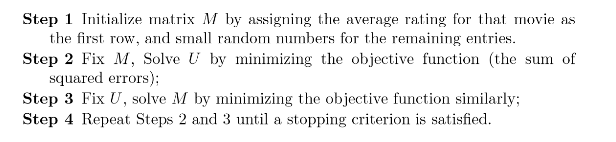

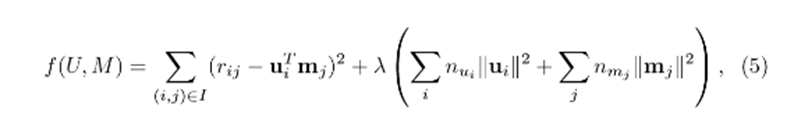

In [69]:
# Repeat until convergence
while k < K:
    # Fix M and solve for U
    for i, Ii in enumerate(I):
        nui = np.count_nonzero(Ii) # Number of items user i has rated
        if (nui == 0): nui = 1 # remove zeros
    
        # Least squares solution
        Ai = np.add(np.dot(M, np.dot(np.diag(Ii), M.T)), np.multiply(l, np.multiply(nui, E))) # A_i = M_{I_i}M_{I_i}^T + ln_{u_i}E
        Vi = np.dot(M, np.dot(np.diag(Ii), R[i].T)) # V_i = M_{I_i}R^T(i,I_i)
        U[:,i] = np.linalg.solve(Ai,Vi).reshape(r)

    # Fix U and solve for M
    for j, Ij in enumerate(I.T):
        nmj = np.count_nonzero(Ij) # Number of users that rated item j
        if (nmj == 0): nmj = 1 # remove zeros

        # Least squares solution
        Aj = np.add(np.dot(U, np.dot(np.diag(Ij), U.T)), np.multiply(l, np.multiply(nmj, E))) # A_j = U_{I_j}U_{I_j}^T + ln_{m_j}E
        Vj = np.dot(U, np.dot(np.diag(Ij), R[:,j])) # V_j = U_{I_j}R(I_j,j)
        try:
            M[:,j] = np.linalg.solve(Aj,Vj).reshape(r)
        except: 
            print("singular matrix error: " + str(j + 1)) # movie has no reviewers 
            continue

    train_rmse = rmse(I,R,M,U)
    test_rmse = rmse(I2,Rtst,M,U)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    #print "[k: %d/%d] train-RMSE = %f  test-RMSE = %f" %(k+1, K, train_rmse, test_rmse)
    k = k + 1

format_output(I2,M,U)
print(test_errors)

[1.4660923250868945, 1.5480692545317587, 1.589313241279779, 1.6009771894594715, 1.6010275136499892]


above are the results for each iteration

In [73]:
print ("[k: %d/%d] train-RMSE = %f  test-RMSE = %f" %(k+1, K, train_rmse, test_rmse))

[k: 6/5] train-RMSE = 0.618053  test-RMSE = 1.601028


In [153]:
cols = ['movieId', 'userId', 'rating']
ratings = pd.read_csv('ratings.csv', usecols = cols)

In [154]:
reader = Reader()
data = Dataset.load_from_df(ratings, reader)

In [155]:
train, test = train_test_split(data, test_size = 0.2)

incorporating biases

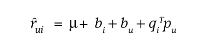

the expected rating is the sum of the average rating plus item bias and user bias and the cross product between item and user

In [156]:
usermean = full.groupby('userId').mean()['rating']
itemmean = full.groupby('movieId').mean()['rating']
average = np.mean(full['rating'])

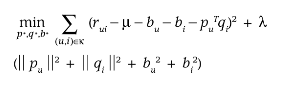

In [157]:
userbias = pd.DataFrame(usermean - average)
itembias = pd.DataFrame(itemmean - average)

In [158]:
iterator = train.all_ratings()
new_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in iterator:
    new_df.loc[i] = [uid, iid, rating]
    i = i+1

new_df.head(2)

,uid,iid,rating
0,0.0,0.0,5.0
1,0.0,100.0,4.0


In [159]:
train_df = new_df

In [160]:
param_grid = {'k': [1],
              'n_epochs':[5, 10],
              'bsl_options': {'method': ['als'],
                              'reg_u': [12, 13]},
              'sim_options': {'name': ['cosine'],
#                               'min_support': [1, 5],
                              'user_based': [False]}
              }

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv = 5)

gs.fit(data)
print(gs.best_score['rmse'])
algo = gs.best_estimator['rmse']
algo.fit(data.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [161]:
print(gs.best_score['rmse'])

1.3488175423806728


In [162]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [163]:
predictions = algo.test(test)

In [164]:
predictions

[Prediction(uid=86, iid=356, r_ui=4.0, est=4.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=414, iid=5209, r_ui=2.0, est=4.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=466, iid=4718, r_ui=4.0, est=4.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=294, iid=327, r_ui=4.0, est=1, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=567, iid=122916, r_ui=3.0, est=2.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=45, iid=2683, r_ui=4.0, est=4.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=125, iid=96829, r_ui=4.5, est=3.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=249, iid=33836, r_ui=2.5, est=3.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=583, iid=39, r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=339, iid=70286, r_ui=3.0, est=4.5, details={'actual_k': 1, 'was_impossible': Fals

In [165]:
accuracy.rmse(predictions, verbose = True)

RMSE: 1.1476


1.1475844714008623

In [166]:
trainarray = np.array(train_df)

In [167]:
trainpredictions = algo.test(trainarray)

In [168]:
accuracy.rmse(trainpredictions, verbose = True)

RMSE: 1.3576


1.357563380754941

In [47]:
print(gs.best_params['rmse'])

{'k': 1, 'n_epochs': 5, 'bsl_options': {'method': 'als', 'reg_u': 12}, 'sim_options': {'name': 'cosine', 'user_based': False}}


temporal dynamics

we chose to separate each day as the bins

In [137]:
cols = ['movieId', 'userId', 'rating']
ratings = pd.read_csv('newtime_bias_data.csv', usecols = cols)

In [138]:
reader = Reader()
data = Dataset.load_from_df(ratings, reader)

In [139]:
train, test = train_test_split(data, test_size = 0.2)

In [140]:
usermean = full.groupby('userId').mean()['rating']
itemmean = full.groupby('movieId').mean()['rating']
average = np.mean(full['rating'])

In [141]:
userbias = pd.DataFrame(usermean - average)
itembias = pd.DataFrame(itemmean - average)

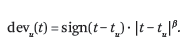

In [142]:
iterator = train.all_ratings()
new_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in iterator:
    new_df.loc[i] = [uid, iid, rating]
    i = i+1

new_df.head(2)

,uid,iid,rating
0,0.0,0.0,4.109188
1,0.0,349.0,5.479261


In [143]:
param_grid = {'k': [1],
              'n_epochs':[5, 10],
              'bsl_options': {'method': ['als'],
                              'reg_u': [12, 13]},
              'sim_options': {'name': ['cosine'],
#                               'min_support': [1, 5],
                              'user_based': [False]}
              }

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv = 5)

gs.fit(data)
print(gs.best_score['rmse'])
algo = gs.best_estimator['rmse']
algo.fit(data.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [144]:
print(gs.best_score['rmse'])

2.641305746740234


In [145]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [146]:
predictions = algo.test(test)

In [147]:
predictions

[Prediction(uid=584, iid=256, r_ui=4.432334212660299, est=4.432334212660299, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=180, iid=315, r_ui=2.13677641757017, est=2.13677641757017, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=560, iid=49278, r_ui=3.3620205952584903, est=4.64534357842064, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=199, iid=2819, r_ui=4.63958006375905, est=3.1395928486850204, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=365, iid=115149, r_ui=4.09005352468805, est=4.09005352468805, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=70, iid=8949, r_ui=7.5614994379001494, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=217, iid=2948, r_ui=2.00618553193286, est=1.63118553193286, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=325, iid=3262, r_ui=2.44886440268447, est=2.03977349359356, details={'actual_k': 1, 'was_impossible': 

In [148]:
accuracy.rmse(predictions, verbose = True)

RMSE: 2.1327


2.1326936792516134

In [150]:
trainarray = np.array(train_df)

In [151]:
trainpredictions = algo.test(trainarray)

In [152]:
accuracy.rmse(trainpredictions, verbose = True)

RMSE: 1.6714


1.6714267717634674

below is the code for post-processing

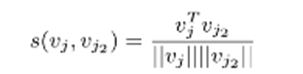

In [115]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

In [116]:

def pairwise_cosin(q):
    """
    Input
    -----
        q: q.csv
    Return
    -----
        """
    

    return 1-pairwise_distances(q.values.T, metric="cosine")

In [117]:
def knn_k_pq(test_movie_id,df,userid):
    """
    Input
    -----
        test_movie_id: the id of movie that want to test,str. for testing purpose should also match same user
        df: df_mat（only pq)
        userid： int
    Return
    -----
        a list of  predicted rating for given movie id for given user given year of matrix
        
        """
    #distance_pair = cosine_similarity_all(test_movie_id)

    movie_index = list(dist_df[0]).index(1)
    user_index = userid
    
    rating_predict = df[user_index][movie_index]
    
    return round(rating_predict,1)

In [118]:
post = pd.DataFrame(np.zeros((610,9724), dtype=np.int))

In [119]:
M
np.save('movie_mat.npy', M)    # .npy extension is added if not given
#d = np.load('movie.npy')

In [120]:
U
np.save('user_mat.npy', U)    # .npy extension is added if not given
#d = np.load('user_mat.npy')

In [121]:
q = pd.DataFrame(M)
output = np.dot(user.T, M)
output = pd.DataFrame(output)
pairwise_dist = pairwise_cosin(q)
dist_df = list(pairwise_dist)

In [ ]:
for i in range(len(output)):
    for j in range(len(output.columns)):
        post[i][j] =  knn_k_pq(j,output,i)

In [ ]:
rmse = np.sqrt(np.sum(np.square(np.multiply(I2, (Rtst-output))))/np.count_nonzero(I2))

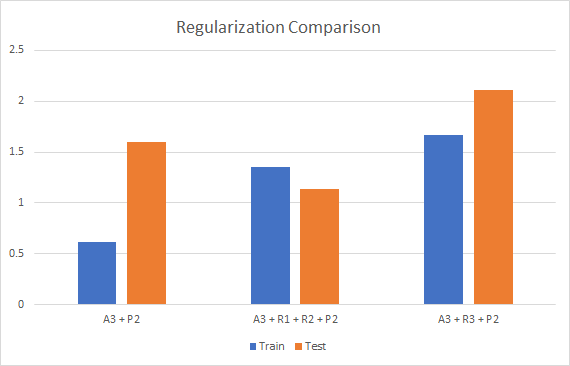